In [21]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

import incense
from incense import ExperimentLoader
import pandas as pd

import sys
sys.path.append('../')

from experiments import sacred_auth_details
from safe_exploration.environments.environments import InvertedPendulum

In [2]:
loader = ExperimentLoader(mongo_uri=sacred_auth_details.db_url, db_name='safe-exploration')

## Recent all experiments

In [ ]:
exps_by_time = loader.find({
    '$query':{
        '$or':[{'status': 'COMPLETED'}, {'status': 'RUNNING'},]}, 
    '$orderby':{'start_time':-1}})
exps_by_time.project(on=['host.hostname', 'command', 'start_time', 'status', 'config.cem_ssm', 
                         'config.mpc_time_horizon', 
                         'config.mc_dropout_hidden_features'])[0:10]

## Recent main experiments

In [41]:
exps_by_time = loader.find({
    '$query':{
        '$or':[{'status': 'COMPLETED'}, {'status': 'RUNNING'},],
        'command': 'main',
        '_id': {'$gt': 230}}, 
    '$orderby':{'start_time':-1}})
exps_by_time.project(on=['host.hostname', 'start_time', 'status', 'config.cem_ssm', 'config.exact_gp_kernel',
                         'config.junk_state_dimen', 'config.cem_beta_safety'])[:10]

,hostname,start_time,status,cem_ssm,exact_gp_kernel,junk_state_dimen,cem_beta_safety
exp_id,,,,,,,
264,oscar-2,2019-07-26 10:07:13.130,RUNNING,exact_gp,nn,0,3.25
263,oscar-1,2019-07-26 09:59:42.987,RUNNING,mc_dropout_gal,rbf,0,3.00
260,oscar-2,2019-07-26 00:08:37.957,COMPLETED,exact_gp,nn,2,3.00
259,oscar-2,2019-07-25 23:23:56.605,COMPLETED,exact_gp,nn,1,3.00
255,oscar-1,2019-07-25 21:47:23.241,COMPLETED,mc_dropout_gal,rbf,0,3.00
254,oscar-1,2019-07-25 19:23:21.841,COMPLETED,exact_gp,rbf,8,3.00
253,oscar-1,2019-07-25 17:51:56.621,COMPLETED,exact_gp,rbf,4,3.00
252,oscar-2,2019-07-25 17:41:18.592,COMPLETED,exact_gp,nn,0,4.50
249,oscar-1,2019-07-25 16:52:29.447,COMPLETED,exact_gp,rbf,2,3.00


## Pendulum experiment details

In [37]:
exps = loader.find_by_ids([243, 244, 249, 248, 259, 260])

# Make sure all experiments have values for all config keys.
config_keys = set()
for exp in exps:
    config_keys.update(exp.config.keys())

for exp in exps:
    for key in config_keys:
        if key not in exp.config.keys():
            exp.config[key] = '?'
            
# Duplicate all metrics so we can use it multiple times in projections.
for exp in exps:
    exp.info['all_metrics2'] = exp.info.all_metrics

def failure_rate(metrics):
    all_lengths = list(itertools.chain.from_iterable(metrics['episode_length'].values()))
    total_steps = sum(all_lengths)
    failures = len(all_lengths) - all_lengths.count(50)
    percent = failures / total_steps * 100
    return f'{failures}/{total_steps} ({percent:.2f}%)'

def fallback_rate(metrics):
    total_steps = sum(itertools.chain.from_iterable(metrics['episode_length'].values()))
    fallback_steps = sum(itertools.chain.from_iterable(metrics['safe_controller_fallback_count'].values()))
    percent = fallback_steps / total_steps * 100
    return f'{fallback_steps}/{total_steps} ({percent:.2f}%)'

def landed(env_results):
    results = list(itertools.chain.from_iterable(env_results.values()))
    total = len(results)
    flying = results.count(0)
    crashed = results.count(1)
    landed = results.count(2)
    return f'{flying}/{crashed}/{landed} : {total}'

frame = exps.project(on=['config.cem_ssm', 
                         'config.mc_dropout_type',
                         'config.cem_beta_safety',
                         'config.exact_gp_kernel',
                         'config.n_scenarios',
                         'config.junk_state_dimen',
                         {'info.all_metrics': failure_rate},
                         {'info.all_metrics2': fallback_rate},
                         {'metrics.sample_volume': max},
                         {'metrics.sample_variance': max}
#                          {'info.all_metrics.env_result': landed},
                        ])
# frame = frame.sort_values(['mc_dropout_hidden_features'])
frame.columns = map(lambda name: name.replace('mc_dropout', 'mcd'), frame.columns)
frame.columns = map(lambda name: name.replace('all_metrics', ''), frame.columns)
frame.columns = map(lambda name: name.replace('cem_beta_safety', 'beta'), frame.columns)

frame

,cem_ssm,mcd_type,beta,exact_gp_kernel,n_scenarios,junk_state_dimen,_failure_rate,2_fallback_rate,sample_volume_max,sample_variance_max
exp_id,,,,,,,,,,
243,exact_gp,concrete,3.0,rbf,6,0,6/2217 (0.27%),645/2217 (29.09%),0.152321,0.021084
244,exact_gp,concrete,3.0,rbf,6,1,1/2351 (0.04%),1291/2351 (54.91%),0.034588,0.002358
249,exact_gp,concrete,3.0,rbf,6,2,0/2400 (0.00%),1212/2400 (50.50%),0.045277,0.002737
248,exact_gp,concrete,3.0,nn,6,0,35/988 (3.54%),414/988 (41.90%),0.126658,0.022455
259,exact_gp,concrete,3.0,nn,6,1,31/1022 (3.03%),794/1022 (77.69%),0.108327,0.016237
260,exact_gp,concrete,3.0,nn,6,2,37/856 (4.32%),520/856 (60.75%),0.124265,0.019787


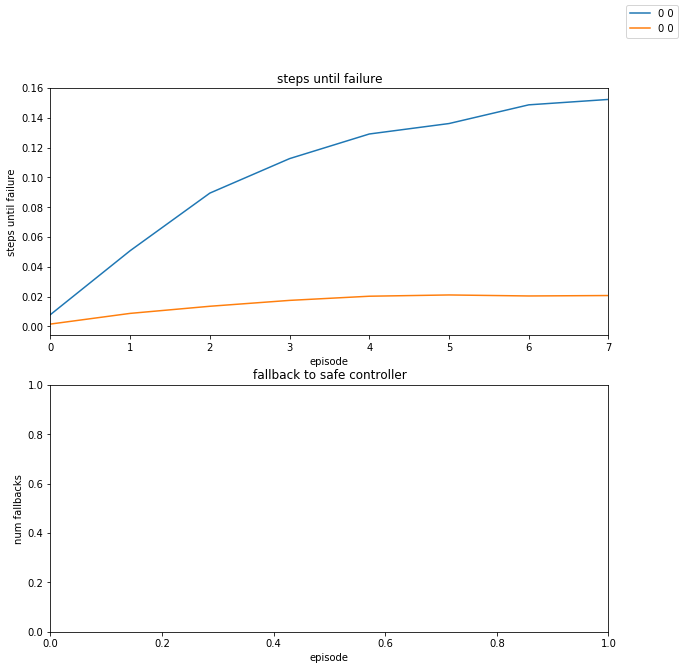

In [5]:
def get_label(exp):
    c = defaultdict(lambda: '?', exp.config)
    return f'{c["junk_state_dimen"]} {c["junk_action_dimen"]}'

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for exp in exps:
    label = get_label(exp)
    exp.metrics['sample_volume'].plot(ax=axes[0], label=label)
    exp.metrics['sample_variance'].plot(ax=axes[0], label=label)
#     exp.metrics['safe_controller_fallback_count'].plot(ax=axes[1], label='')
    
axes[0].set_ylabel('steps until failure')
axes[0].set_xlabel('episode')
axes[0].set_title('steps until failure')

axes[1].set_ylabel('num fallbacks')
axes[1].set_xlabel('episode')
axes[1].set_title('fallback to safe controller')

fig.legend()

In [33]:
exp = loader.find_by_id(244)
artifacts = exp.artifacts
print(artifacts.keys())
states = None
env = InvertedPendulum(simple_constraints=exp.config[''])
axes = plt.axes()
env.plot_states(axes, states, False)
plt.show()

dict_keys(['244_trajectories_0_0.png', '244_training_points_0_0.png', '244_trajectories_0_1.png', '244_training_points_0_1.png', '244_trajectories_0_2.png', '244_training_points_0_2.png', '244_trajectories_0_3.png', '244_training_points_0_3.png', '244_trajectories_0_4.png', '244_training_points_0_4.png', '244_trajectories_0_5.png', '244_training_points_0_5.png', '244_trajectories_0_6.png', '244_training_points_0_6.png', '244_trajectories_0_7.png', '244_training_points_0_7.png', '244_trajectories_1_0.png', '244_training_points_1_0.png', '244_trajectories_1_1.png', '244_training_points_1_1.png', '244_trajectories_1_2.png', '244_training_points_1_2.png', '244_trajectories_1_3.png', '244_training_points_1_3.png', '244_trajectories_1_4.png', '244_training_points_1_4.png', '244_trajectories_1_5.png', '244_training_points_1_5.png', '244_trajectories_1_6.png', '244_training_points_1_6.png', '244_trajectories_1_7.png', '244_training_points_1_7.png', '244_trajectories_2_0.png', '244_training_poi

KeyError: ''

## Failed episode dropout investigation

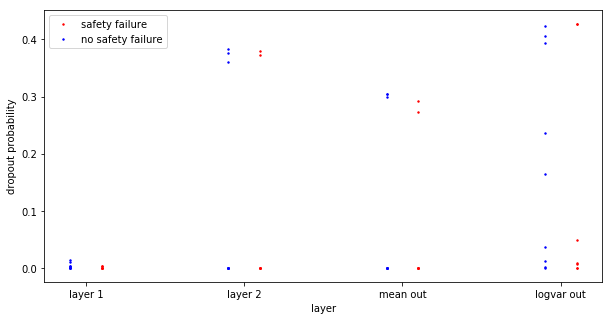

In [82]:
def map_name(name):
    if name == 'dropout_p_conc_drop1':
        return 'layer 1'
    if name == 'dropout_p_conc_drop2':
        return 'layer 2'
    if name == 'dropout_p_conc_drop_logvar':
        return 'logvar out'
    if name == 'dropout_p_conc_drop_mu':
        return 'mean out'
    return name

exp = loader.find_by_id(121)
dropout_metrics = {map_name(k): v for k,v in exp.info.all_metrics.items() if k.startswith('dropout_p')}
failed_episodes = [(1, 0), (1,1), (0,3), (0,5), (1,5), (0,6), (1,6)]

# Compare average p on non-failures, to value of p during failures

success_labels = []
success_data = []
failure_labels = []
failure_data = []

for metric_name, metric_data in dropout_metrics.items():
    for episode in range(len(metric_data)):
        episode_key = f'json://{episode}'
        for scenario in range(len(metric_data[episode_key])):
            if (scenario, episode) in failed_episodes:
                failure_labels.append(metric_name)
                failure_data.append(metric_data[episode_key][scenario])
            else:
                success_labels.append(metric_name)
                success_data.append(metric_data[episode_key][scenario])
                
label_vals = {
    'layer 1': 1.,
    'layer 2': 2.,
    'mean out': 3.,
    'logvar out': 4.
}
success_labels = [label_vals[label] - 0.1 for label in success_labels]
failure_labels = [label_vals[label] + 0.1 for label in failure_labels]

plt.figure(figsize=(10,5))
plt.scatter(failure_labels, failure_data, color='red', s=2, label='safety failure')
plt.scatter(success_labels, success_data, color='blue', s=2, label='no safety failure')
plt.xticks(list(label_vals.values()), list(label_vals.keys()))
plt.xlabel('layer')
plt.ylabel('dropout probability')
plt.legend()
plt.show()

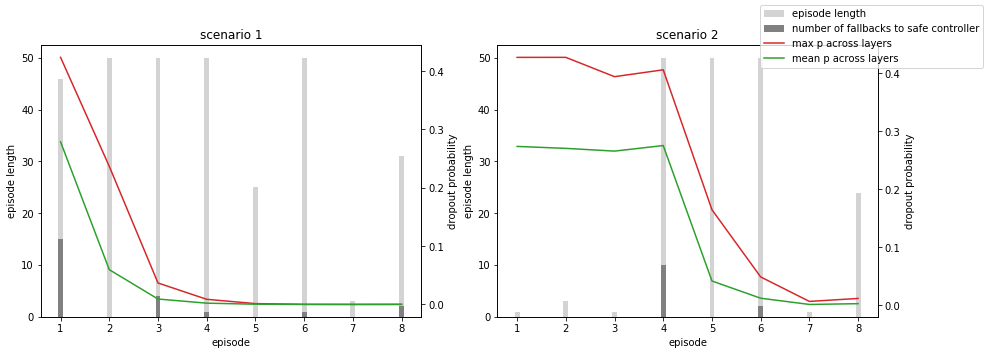

In [144]:
num_episodes = len(dropout_metrics['layer 1'])
num_scenarios = len(dropout_metrics['layer 1']['json://0'])
means = np.empty((num_scenarios, num_episodes))
maxes = np.empty((num_scenarios, num_episodes))
mins = np.empty((num_scenarios, num_episodes))
lengths = np.empty((num_scenarios, num_episodes))
fallbacks = np.empty((num_scenarios, num_episodes))
for episode in range(num_episodes):
    episode_key = f'json://{episode}'
    for scenario in range(num_scenarios):
        ps = [metric[episode_key][scenario] for metric in dropout_metrics.values()]
        mean = sum(ps) / len(ps)
        means[scenario, episode] = mean
        maxes[scenario, episode] = max(ps)
        mins[scenario, episode] = min(ps)
        
        lengths[scenario, episode] = exp.info.all_metrics.episode_length[episode_key][scenario]
        fallbacks[scenario, episode] = exp.info.all_metrics.safe_controller_fallback_count[episode_key][scenario]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
episodes = range(1, num_episodes + 1)

ax1.bar(episodes, lengths[0], width=0.1, color='lightgrey', label='episode length')
ax1.bar(episodes, fallbacks[0], width=0.1, color='grey', label='number of fallbacks to safe controller')
ax1.set_title('scenario 1')
ax1.set_ylabel('episode length')
ax1.set_xlabel('episode')
ax1b = ax1.twinx()
ax1b.plot(episodes, maxes[0], label='max p across layers', color='C3')
ax1b.plot(episodes, means[0], label='mean p across layers', color='C2')
ax1b.set_ylabel('dropout probability')

ax2.bar(episodes, lengths[1], width=0.1, color='lightgrey')
ax2.bar(episodes, fallbacks[1], width=0.1, color='grey')
ax2.set_title('scenario 2')
ax2.set_ylabel('episode length')
ax2.set_xlabel('episode')
ax2b = ax2.twinx()
ax2b.plot(episodes, maxes[1], label='', color='C3')
ax2b.plot(episodes, means[1], label='', color='C2')
ax2b.set_ylabel('dropout probability')
fig.legend()
plt.show()

## Failed experiments

In [39]:
exps_by_time = loader.find({
    '$query':{
        'status': 'FAILED',
        'command': 'main',
        '_id': {'$gt': 230}}, 
    '$orderby':{'start_time':-1}})
exps_by_time.project(on=['host.hostname', 'start_time', 'status', 'config.cem_ssm',  
                         'config.cem_beta_safety', 'config.exact_gp_kernel'])[0:10]

,hostname,start_time,status,cem_ssm,cem_beta_safety,exact_gp_kernel
exp_id,,,,,,
261,oscar-1,2019-07-26 01:17:21.001,FAILED,mc_dropout_gal,3.00,rbf
258,oscar-2,2019-07-25 22:35:27.370,FAILED,exact_gp,3.75,nn
257,oscar-2,2019-07-25 21:53:16.314,FAILED,exact_gp,3.50,nn
256,oscar-2,2019-07-25 21:49:09.817,FAILED,exact_gp,3.25,nn
251,oscar-2,2019-07-25 17:30:23.176,FAILED,exact_gp,4.00,nn
250,oscar-2,2019-07-25 17:04:31.708,FAILED,exact_gp,3.50,nn
247,oscar-2,2019-07-25 16:08:27.929,FAILED,exact_gp,3.00,nn
246,oscar-2,2019-07-25 16:01:41.394,FAILED,exact_gp,3.00,nn
245,oscar-2,2019-07-25 16:00:57.691,FAILED,exact_gp,3.00,nn


In [40]:
for line in loader.find_by_id(256).fail_trace:
    print(line)

Traceback (most recent call last):

  File "/home/oscar/.local/share/virtualenvs/safe-exploration-R2Du0wwh/lib/python3.7/site-packages/wrapt/wrappers.py", line 564, in __call__
    args, kwargs)

  File "/home/oscar/.local/share/virtualenvs/safe-exploration-R2Du0wwh/lib/python3.7/site-packages/sacred/config/captured_function.py", line 47, in captured_function
    result = wrapped(*args, **kwargs)

  File "./run.py", line 99, in main
    _run_scenario()

  File "/home/oscar/.local/share/virtualenvs/safe-exploration-R2Du0wwh/lib/python3.7/site-packages/wrapt/wrappers.py", line 564, in __call__
    args, kwargs)

  File "/home/oscar/.local/share/virtualenvs/safe-exploration-R2Du0wwh/lib/python3.7/site-packages/sacred/config/captured_function.py", line 47, in captured_function
    result = wrapped(*args, **kwargs)

  File "./run.py", line 81, in _run_scenario
    run_episodic(conf, metrics)

  File "/home/oscar/safe-exploration/safe_exploration/episode_runner.py", line 76, in run_episodic


In [35]:
for line in loader.find_by_id(223).captured_out.split('\n'):
    print(line)

INFO - sacred_helper - Running command 'main'
INFO - sacred_helper - Started run with ID "223"
safempc_cem_InvertedPendulum_nsafe=1_nperf=0_r=1_beta_safety=2_0
/home/oscar/safe-exploration/safe_exploration/environments/environments.py:426: UserWarning: Normalization turned off for now. Need to look into it
  warnings.warn("Normalization turned off for now. Need to look into it")
/home/oscar/safe-exploration/safe_exploration/episode_runner.py:30: UserWarning: Need to check relative dynamics
  warnings.warn("Need to check relative dynamics")
/home/oscar/safe-exploration/safe_exploration/utils_config.py:58: UserWarning: Normalization of constraints may be wrong!
  warnings.warn("Normalization of constraints may be wrong!")
Training GP on 25 data points for 200 iterations...
Training complete. Final losses: -0.13 -0.14 -0.15 -0.16
Starting episode 1/8 in scenario 1/6
Using safe controller
total time solver in ms: 0.17370009422302246

===Old state unnormalized:
[ 0.05158 -0.05543]
===Action


==== Applied normalized action at time step 23 ====
[0.00015]

==== Next state (normalized) ====
[ 0.00092 -0.00033]

Using safe controller
total time solver in ms: 0.23731279373168945

===Old state unnormalized:
[ 0.00092 -0.00033]
===Action unnormalized:
[0.00013]
===Next state unnormalized:
[ 0.0008  -0.00029]
Immediate cost for current step: [0]

==== Applied normalized action at time step 24 ====
[0.00013]

==== Next state (normalized) ====
[ 0.0008  -0.00029]

Using safe controller
total time solver in ms: 0.22036242485046387

===Old state unnormalized:
[ 0.0008  -0.00029]
===Action unnormalized:
[0.00012]
===Next state unnormalized:
[ 0.00069 -0.00025]
Immediate cost for current step: [0]

==== Applied normalized action at time step 25 ====
[0.00012]

==== Next state (normalized) ====
[ 0.00069 -0.00025]

Using safe controller
total time solver in ms: 0.20926952362060547

===Old state unnormalized:
[ 0.00069 -0.00025]
===Action unnormalized:
[0.0001]
===Next state unnormalized:

[-0.16093]

==== Next state (normalized) ====
[-0.05766  0.00484]

Found solution
total time solver in ms: 0.6371622085571289

===Old state unnormalized:
[-0.05766  0.00484]
===Action unnormalized:
[-0.09254]
===Next state unnormalized:
[-0.19391 -0.00174]
Immediate cost for current step: [0]

==== Applied normalized action at time step 29 ====
[-0.09254]

==== Next state (normalized) ====
[-0.19391 -0.00174]

Using existing solution
total time solver in ms: 0.6408956050872803

===Old state unnormalized:
[-0.19391 -0.00174]
===Action unnormalized:
[0.15377]
===Next state unnormalized:
[ 0.00138 -0.00665]
Immediate cost for current step: [0]

==== Applied normalized action at time step 30 ====
[0.15377]

==== Next state (normalized) ====
[ 0.00138 -0.00665]

Found solution
total time solver in ms: 0.6317634582519531

===Old state unnormalized:
[ 0.00138 -0.00665]
===Action unnormalized:
[0.08194]
===Next state unnormalized:
[ 0.11147 -0.00369]
Immediate cost for current step: [0]

==== 


Using safe controller
total time solver in ms: 0.2064363956451416

===Old state unnormalized:
[ 0.00001 -0.     ]
===Action unnormalized:
[0.]
===Next state unnormalized:
[ 0.00001 -0.     ]
Immediate cost for current step: [0]

==== Applied normalized action at time step 47 ====
[0.]

==== Next state (normalized) ====
[ 0.00001 -0.     ]

Using safe controller
total time solver in ms: 0.18753528594970703

===Old state unnormalized:
[ 0.00001 -0.     ]
===Action unnormalized:
[0.]
===Next state unnormalized:
[ 0.00001 -0.     ]
Immediate cost for current step: [0]

==== Applied normalized action at time step 48 ====
[0.]

==== Next state (normalized) ====
[ 0.00001 -0.     ]

Using safe controller
total time solver in ms: 0.17621374130249023

===Old state unnormalized:
[ 0.00001 -0.     ]
===Action unnormalized:
[0.]
===Next state unnormalized:
[ 0.00001 -0.     ]
Immediate cost for current step: [0]

==== Applied normalized action at time step 49 ====
[0.]

==== Next state (normalize

[0.02951]

==== Next state (normalized) ====
[ 0.11289 -0.04647]

Using safe controller
total time solver in ms: 0.6261365413665771

===Old state unnormalized:
[ 0.11289 -0.04647]
===Action unnormalized:
[0.02446]
===Next state unnormalized:
[ 0.10434 -0.04103]
Immediate cost for current step: [0]

==== Applied normalized action at time step 7 ====
[0.02446]

==== Next state (normalized) ====
[ 0.10434 -0.04103]

Using safe controller
total time solver in ms: 0.664935827255249

===Old state unnormalized:
[ 0.10434 -0.04103]
===Action unnormalized:
[0.02003]
===Next state unnormalized:
[ 0.09389 -0.03608]
Immediate cost for current step: [0]

==== Applied normalized action at time step 8 ====
[0.02003]

==== Next state (normalized) ====
[ 0.09389 -0.03608]

Using safe controller
total time solver in ms: 0.6212723255157471

===Old state unnormalized:
[ 0.09389 -0.03608]
===Action unnormalized:
[0.01689]
===Next state unnormalized:
[ 0.08324 -0.03167]
Immediate cost for current step: [0]


===Old state unnormalized:
[-0.24654  0.02848]
===Action unnormalized:
[0.44083]
===Next state unnormalized:
[0.23041 0.02552]
Immediate cost for current step: [0]

==== Applied normalized action at time step 5 ====
[0.44083]

==== Next state (normalized) ====
[0.23041 0.02552]

Found solution
total time solver in ms: 0.9200217723846436

===Old state unnormalized:
[0.23041 0.02552]
===Action unnormalized:
[-0.2627]
===Next state unnormalized:
[-0.01612  0.03255]
Immediate cost for current step: [0]

==== Applied normalized action at time step 6 ====
[-0.2627]

==== Next state (normalized) ====
[-0.01612  0.03255]

Found solution
total time solver in ms: 0.9802360534667969

===Old state unnormalized:
[-0.01612  0.03255]
===Action unnormalized:
[0.08236]
===Next state unnormalized:
[0.09162 0.03365]
Immediate cost for current step: [0]

==== Applied normalized action at time step 7 ====
[0.08236]

==== Next state (normalized) ====
[0.09162 0.03365]

Found solution
total time solver in ms


===Old state unnormalized:
[ 0.0083  -0.00297]
===Action unnormalized:
[0.00121]
===Next state unnormalized:
[ 0.00719 -0.00259]
Immediate cost for current step: [0]

==== Applied normalized action at time step 26 ====
[0.00121]

==== Next state (normalized) ====
[ 0.00719 -0.00259]

Using safe controller
total time solver in ms: 0.17192935943603516

===Old state unnormalized:
[ 0.00719 -0.00259]
===Action unnormalized:
[0.00106]
===Next state unnormalized:
[ 0.00627 -0.00225]
Immediate cost for current step: [0]

==== Applied normalized action at time step 27 ====
[0.00106]

==== Next state (normalized) ====
[ 0.00627 -0.00225]

Using safe controller
total time solver in ms: 0.1831800937652588

===Old state unnormalized:
[ 0.00627 -0.00225]
===Action unnormalized:
[0.00092]
===Next state unnormalized:
[ 0.00543 -0.00196]
Immediate cost for current step: [0]

==== Applied normalized action at time step 28 ====
[0.00092]

==== Next state (normalized) ====
[ 0.00543 -0.00196]

Using saf

 [ 0.00009 -0.00003  0.00001]]
Training GP on 172 data points for 200 iterations...
Training complete. Final losses: -5.59 -5.59 -5.60 -5.60
Starting episode 4/8 in scenario 3/6
Using safe controller
total time solver in ms: 0.6307101249694824

===Old state unnormalized:
[ 0.05263 -0.06945]
===Action unnormalized:
[0.07562]
===Next state unnormalized:
[ 0.08687 -0.06598]
Immediate cost for current step: [0]

==== Applied normalized action at time step 0 ====
[0.07562]

==== Next state (normalized) ====
[ 0.08687 -0.06598]

Using safe controller
total time solver in ms: 0.6675689220428467

===Old state unnormalized:
[ 0.08687 -0.06598]
===Action unnormalized:
[0.05943]
===Next state unnormalized:
[ 0.11067 -0.06094]
Immediate cost for current step: [0]

==== Applied normalized action at time step 1 ====
[0.05943]

==== Next state (normalized) ====
[ 0.11067 -0.06094]

Using safe controller
total time solver in ms: 0.6106986999511719

===Old state unnormalized:
[ 0.11067 -0.06094]
===Act

 [ 0.17065  0.01459  0.00525]
 [ 0.16254  0.02221 -0.26521]
 [-0.1078   0.0248   0.00295]
 [-0.15211  0.01694 -0.02552]
 [-0.16527  0.0092   0.25891]]
Training GP on 270 data points for 200 iterations...
Training complete. Final losses: -5.88 -5.88 -5.88 -5.88
Starting episode 6/8 in scenario 3/6
Found solution
total time solver in ms: 0.7826375961303711

===Old state unnormalized:
[-0.04305  0.01738]
===Action unnormalized:
[-0.26593]
===Next state unnormalized:
[-0.3844   0.00674]
Immediate cost for current step: [0]

==== Applied normalized action at time step 0 ====
[-0.26593]

==== Next state (normalized) ====
[-0.3844   0.00674]

Found solution
total time solver in ms: 0.7602896690368652

===Old state unnormalized:
[-0.3844   0.00674]
===Action unnormalized:
[0.54035]
===Next state unnormalized:
[ 0.18371 -0.00151]
Immediate cost for current step: [0]

==== Applied normalized action at time step 1 ====
[0.54035]

==== Next state (normalized) ====
[ 0.18371 -0.00151]

Found soluti